In [3]:
## Libraries

import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
from fredapi import Fred

import matplotlib.pyplot as plt


In [4]:
## Connect to FRED

load_dotenv()
fred = Fred(api_key=os.getenv("FRED_API_KEY"))


In [5]:
# Get correct FRED series

results = fred.search("loan loss provisions")
results[["id", "title", "frequency", "notes"]].head(15)




,id,title,frequency,notes
series id,,,,
QBPQYLNLOSS,QBPQYLNLOSS,Income and Expense: Provision for Loan and Lea...,Quarterly,This series is found in Quarterly Income and E...


In [6]:
# Prepare data

llp = fred.get_series("QBPQYLNLOSS")
llp = llp.to_frame(name="llp")
llp.index = pd.to_datetime(llp.index)
llp = llp.sort_index()


llp.head()




,llp
1984-01-01,2142.141
1984-04-01,3565.992
1984-07-01,3367.472
1984-10-01,4888.653
1985-01-01,3019.247


In [15]:
## Index discipline

type(llp.index)

llp.index[:5]

DatetimeIndex(['1984-01-01', '1984-04-01', '1984-07-01', '1984-10-01',
               '1985-01-01'],
              dtype='datetime64[us]', freq=None)

In [ ]:
# Check spacing

llp.index.to_series().diff().value_counts()

92 days    82
91 days    53
90 days    31
Name: count, dtype: int64

In [ ]:
# Check sorting

llp.index.is_monotonic_increasing

True

In [17]:
# Confirm index

llp.head(8)

,llp
1984-01-01,2142.141
1984-04-01,3565.992
1984-07-01,3367.472
1984-10-01,4888.653
1985-01-01,3019.247
1985-04-01,4367.542
1985-07-01,4365.684
1985-10-01,6289.122


In [18]:
# Pull macro series

unrate = fred.get_series("UNRATE").to_frame(name="unemployment")
indpro = fred.get_series("INDPRO").to_frame(name="indpro")
spread = fred.get_series("T10Y3M").to_frame(name="term_spread")
recession = fred.get_series("USREC").to_frame(name="recession")

In [19]:
# Index discipline

for df_ in [unrate, indpro, spread, recession]:
    df_.index = pd.to_datetime(df_.index)
    df_.sort_index(inplace=True)

In [ ]:
# Confirm spacing

unrate.index.to_series().diff().value_counts().head()

31 days    546
30 days    312
28 days     58
29 days     20
Name: count, dtype: int64

In [21]:
# Resample to Quarter Start

unrate_q = unrate.resample("QS").mean()
indpro_q = indpro.resample("QS").mean()
spread_q = spread.resample("QS").mean()

recession_q = recession.resample("QS").max()


In [26]:
# Confirm alignment
print("LLP:")
print(llp.head())

print("\nUNRATE Quarterly:")
print(unrate_q.head())

print("indpro_q:")
print(indpro_q.head())

print("spread_q:")
print(spread_q.head())

print("recession_q:")
print(recession_q.head())

LLP:
                 llp
1984-01-01  2142.141
1984-04-01  3565.992
1984-07-01  3367.472
1984-10-01  4888.653
1985-01-01  3019.247

UNRATE Quarterly:
            unemployment
1948-01-01      3.733333
1948-04-01      3.666667
1948-07-01      3.766667
1948-10-01      3.833333
1949-01-01      4.666667
indpro_q:
              indpro
1919-01-01  4.685400
1919-04-01  4.721267
1919-07-01  5.241867
1919-10-01  5.116267
1920-01-01  5.591967
spread_q:
            term_spread
1982-01-01     0.798689
1982-04-01     0.890476
1982-07-01     3.438750
1982-10-01     2.493115
1983-01-01     2.157143
recession_q:
            recession
1854-10-01        1.0
1855-01-01        0.0
1855-04-01        0.0
1855-07-01        0.0
1855-10-01        0.0


In [24]:
# Join llp and unemp


df = llp.join(unrate_q, how="inner")

In [ ]:
# Check date

print(df.index.min())

1984-01-01 00:00:00


In [28]:
# Merge the rest
df = df.join(indpro_q, how="inner")
df = df.join(recession_q, how="inner")
df = df.join(spread_q, how="inner")

In [31]:
print("Index type:", type(df.index))
print("Monotonic:", df.index.is_monotonic_increasing)

print("\nStart date:", df.index.min())
print("End date:", df.index.max())
print("Number of observations:", len(df))

print("\nAny NaNs?")
print(df.isna().sum())

df.index.equals(df.index.sort_values())

Index type: <class 'pandas.DatetimeIndex'>
Monotonic: True

Start date: 1984-01-01 00:00:00
End date: 2025-07-01 00:00:00
Number of observations: 167

Any NaNs?
llp             0
unemployment    0
indpro          0
recession       0
term_spread     0
dtype: int64


True

In [32]:
# Plot and Save our figure

#import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(df.index, df["llp"])
plt.title("Loan Loss Provisions (All Commercial Banks)")
plt.ylabel("Millions of Dollars")
plt.xlabel("Date")
plt.tight_layout()
plt.savefig("../figures/llp_over_time.png", dpi=300)
plt.close()

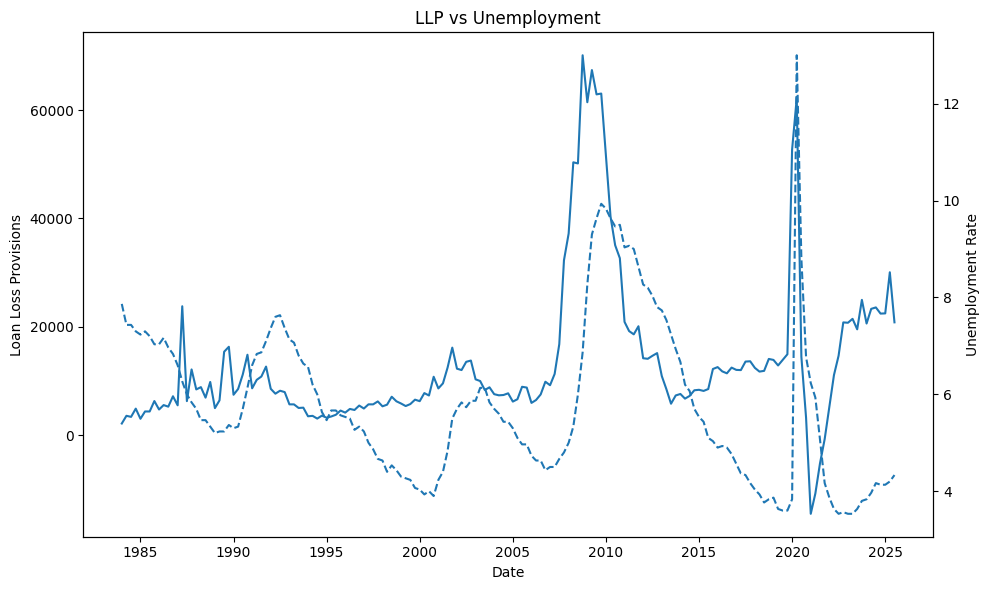

In [36]:
fig, ax1 = plt.subplots(figsize=(10,6))

ax1.plot(df.index, df["llp"])
ax1.set_ylabel("Loan Loss Provisions")
ax1.set_xlabel("Date")

ax2 = ax1.twinx()
ax2.plot(df.index, df["unemployment"], linestyle="--")
ax2.set_ylabel("Unemployment Rate")

plt.title("LLP vs Unemployment")
plt.tight_layout()

plt.show()   # <-- this makes it display

In [ ]:
# Let's save our dataset 

df.index.name = "DATE"

import os
print(os.getcwd())

#df.to_csv("../data/processed/quarterly_llp_macro.csv")

/Users/lukeroy/Documents/4915_capstone/notebooks


In [ ]:
# Verify file exists

os.path.exists("../data/processed/quarterly_llp_macro.csv")

True